In [2]:
import retro
import numpy as np
import scipy.ndimage
import glob
import pandas as pd
from mario_replays import replay_bk2
from mario_replays.utils import get_variables_from_replay
from mario_replays.load_data import collect_bk2_files
%pylab inline
import os.path as op
from mario_scenes.load_data import load_scenes_info
from mario_replays.load_data import load_replay_sidecars
from PIL import Image
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA_PATH = '/home/hyruuk/GitHub/neuromod/mario_repos/mario.scenes/data/mario/'
replays_dir = op.join('..','..','mario.replays', 'data', 'mario', 'derivatives', 'replays')

retro.data.Integrations.add_custom_path(op.join(DATA_PATH, 'stimuli'))
scenes_info_dict = load_scenes_info(format='dict')
bk2_list = collect_bk2_files(DATA_PATH, subjects='sub-01')

In [4]:
# create a function to get the maximum position reached for a given level_fullname
def get_max_position(replays_dir, level_fullname='w1l1'):
    sidecars_df = load_replay_sidecars(replays_dir)
    level_df = sidecars_df[sidecars_df['level_fullname']==level_fullname]
    return level_df['Final_position'].max()

In [ ]:
bk2_list = collect_bk2_files(DATA_PATH, subjects='sub-01')
sidecar_name = op.join(replays_dir, bk2_info['bk2_file']).replace('.bk2','.json')
with open(sidecar_name, 'r') as f:
    sidecar_info = json.load(f)


{'World': '1',
 'Level': '3',
 'Duration': 46.75,
 'Cleared': False,
 'Final_score': 40,
 'Final_position': 1103,
 'Lives_lost': 3,
 'Hits_taken': 3,
 'Enemies_killed': 0,
 'Powerups_collected': 0,
 'Bricks_destroyed': 0,
 'Coins': 2,
 'idx_in_run': 0,
 'run': 'run-03',
 'global_idx': 21,
 'level_idx': 0,
 'phase': 'discovery',
 'level_fullname': 'w1l3'}

In [5]:
import numpy as np
from collections import Counter

def mode_array(arrays):
    """
    Finds the most common (mode) 2D array in a list of arrays.
    
    Parameters:
        arrays (list of np.ndarray): List of 2D NumPy arrays.
        
    Returns:
        np.ndarray: The array that occurs most frequently in the list.
    """
    # Convert each 2D array to a hashable type (tuple of tuples)
    hashable_arrays = [tuple(map(tuple, arr)) for arr in arrays]
    
    # Count occurrences using Counter
    counter = Counter(hashable_arrays)
    
    # Get the most common array (mode) and its frequency (if needed)
    mode_tuple, frequency = counter.most_common(1)[0]
    print(f'Most common array occurs {frequency} times.')
    
    # Convert the tuple back to a NumPy array
    mode_arr = np.array(mode_tuple)
    
    return mode_arr

In [6]:
### Takes mode across all reps for each column

level_list = np.unique([x[:4] for x in scenes_info_dict.keys()])
for level_todo in level_list:
    print(f'Creating background for level {level_todo}')
    # First, accumulate columns across all the replays for this level
    #level_collected = False
    background_frame = None
    
    scenes_in_level = [x for x in scenes_info_dict.keys() if x[:4] == level_todo]
    layouts = [scenes_info_dict[x]['level_layout'] for x in scenes_in_level]
    values, counts = np.unique(layouts, return_counts=True)
    most_common_layout = values[np.argsort(counts)[-1]]
    
    max_level_position = get_max_position(replays_dir, level_fullname=level_todo)
    
    columns_dict = {}
    for i in range(max_level_position):
        columns_dict[i] = []

    for bk2_info in bk2_list:
        bk2_file = bk2_info['bk2_file']
        skip_first_step = bk2_info['bk2_idx'] == 0
        bk2_level_fullname = bk2_info['bk2_file'].split('_')[-2].split('-')[1]
        if bk2_level_fullname == level_todo:
            print(f'Processing {bk2_file}')
            repetition_variables, replay_info, replay_frames, replay_states = get_variables_from_replay(
                op.join(DATA_PATH, bk2_file),
                skip_first_step=skip_first_step
            )
            # compute long version of x variables
            repetition_variables['player_x_pos'] = [
                hi * 256 + lo for hi, lo in zip(repetition_variables['player_x_posHi'], repetition_variables['player_x_posLo'])
            ]
            repetition_variables['scroll_x_pos'] = [
                hi * 256 + lo for hi, lo in zip(repetition_variables['xscrollHi'], repetition_variables['xscrollLo'])
            ]

            #if needed, init scene_layout
            if background_frame is None:
                background_frame = np.zeros((replay_frames[0].shape[0], max_level_position, replay_frames[0].shape[2]))

            for i, frame in enumerate(replay_frames):
                if repetition_variables['level_layout'][i] == most_common_layout:
                    x_scroll_pos = repetition_variables['scroll_x_pos'][i]
                    x_scroll_pos_r = x_scroll_pos + 240
                    for col in range(240):
                        try:
                            columns_dict[x_scroll_pos + col].append(frame[:, col, :])
                        except:
                            continue

            
    for i in range(max_level_position):
        column = mode_array(columns_dict[i])
        background_frame[:,i,:] = column
        print(f'Column {i} done')
    
    img = Image.fromarray(np.uint8(background_frame))
    os.makedirs(op.join('..', 'resources', 'scene_backgrounds'), exist_ok=True)
    img.save(op.join('..', 'resources', 'scene_backgrounds', f'{level_todo}.png'))


Creating background for level w1l1
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2


KeyboardInterrupt: 

In [11]:
### Takes only 1 column per column.

columns_batch = 21

level_list = np.unique([x[:4] for x in scenes_info_dict.keys()])
for level_todo in level_list:
    print(f'Creating background for level {level_todo}')
    # First, accumulate columns across all the replays for this level
    level_collected = False
    background_frame = None
    
    scenes_in_level = [x for x in scenes_info_dict.keys() if x[:4] == level_todo]
    layouts = [scenes_info_dict[x]['level_layout'] for x in scenes_in_level]
    values, counts = np.unique(layouts, return_counts=True)
    most_common_layout = values[np.argsort(counts)[-1]]
    
    max_level_position = get_max_position(replays_dir, level_fullname=level_todo)
    
    columns_to_fill = np.ones(max_level_position)

    for bk2_info in bk2_list:
        if not level_collected:
            bk2_file = bk2_info['bk2_file']
            skip_first_step = bk2_info['bk2_idx'] == 0
            bk2_level_fullname = bk2_info['bk2_file'].split('_')[-2].split('-')[1]
            if bk2_level_fullname == level_todo:
                print(f'Processing {bk2_file}')
                repetition_variables, replay_info, replay_frames, replay_states = get_variables_from_replay(
                    op.join(DATA_PATH, bk2_file),
                    skip_first_step=skip_first_step
                )
                # compute long version of x variables
                repetition_variables['player_x_pos'] = [
                    hi * 256 + lo for hi, lo in zip(repetition_variables['player_x_posHi'], repetition_variables['player_x_posLo'])
                ]
                repetition_variables['scroll_x_pos'] = [
                    hi * 256 + lo for hi, lo in zip(repetition_variables['xscrollHi'], repetition_variables['xscrollLo'])
                ]

                #if needed, init scene_layout
                if background_frame is None:
                    background_frame = np.zeros((replay_frames[0].shape[0], max_level_position, replay_frames[0].shape[2]))

                for i, frame in enumerate(replay_frames):
                    if repetition_variables['level_layout'][i] == most_common_layout:
                        x_scroll_pos = repetition_variables['scroll_x_pos'][i]
                        for col in range(columns_batch):
                            try:
                                if columns_to_fill[x_scroll_pos + col]:
                                    background_frame[:,x_scroll_pos + col,:] = frame[:, col, :]
                                    columns_to_fill[x_scroll_pos + col] = 0
                            except:
                                continue
                print(f'Number of columns left to fill : {np.sum(columns_to_fill)}')
                if not np.any(columns_to_fill):
                    level_collected = True
    
    img = Image.fromarray(np.uint8(background_frame))
    os.makedirs(op.join('..', 'resources', 'scene_backgrounds'), exist_ok=True)
    img.save(op.join('..', 'resources', 'scene_backgrounds', f'{level_todo}.png'))


Creating background for level w1l1
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2
Number of columns left to fill : 0.0
Creating background for level w1l2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-000.bk2
Number of columns left to fill : 1093.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-001.bk2
Number of columns left to fill : 310.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-002.bk2
Number of columns left to fill : 310.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-003.bk2
Number of columns left to fill : 310.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-004.bk2
Number of columns left to fill : 309.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-005.bk2
Number of columns left to fill : 309.0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l

Creating background for level w1l1
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2


ZeroDivisionError: division by zero

Saved mosaic as 'background.png'.


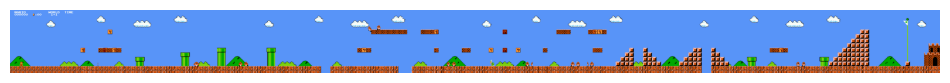

In [76]:
import os.path as op
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_mosaic_from_replay(repetition_variables, replay_frames, level_layout, columns_per_frame):
    """
    Creates a full-level mosaic image from replay data using a rightmost-columns strategy.
    
    Only frames where:
      - repetition_variables['level_layout'] equals level_layout, and
      - repetition_variables['player_state'] equals 8
    are processed.
    
    For these valid frames:
      - The first valid frame (with the lowest scroll_x_pos) is fully accumulated.
      - For every subsequent valid frame, only the rightmost 'columns_per_frame'
        columns are accumulated into the mosaic.
    
    The mosaic is constructed horizontally based on the scroll_x_pos values.
    
    Parameters:
        repetition_variables (dict): Replay variables (must include keys:
                                       'xscrollHi', 'xscrollLo', 'level_layout', 'player_state').
        replay_frames (list): List of frame images (as RGB NumPy arrays).
        level_layout (int): Only frames with repetition_variables['level_layout'] equal to this value are used.
        columns_per_frame (int): Number of columns (from the right side) to take from each frame 
                                 (except for the first valid frame, which uses the full frame).
    
    Returns:
        np.ndarray: The mosaic image as an RGB (uint8) NumPy array.
    """
    # Compute scroll_x_pos from xscrollHi and xscrollLo
    repetition_variables['scroll_x_pos'] = [
        hi * 256 + lo for hi, lo in zip(
            repetition_variables['xscrollHi'], repetition_variables['xscrollLo']
        )
    ]
    
    frames = replay_frames
    scrolls = repetition_variables["scroll_x_pos"]
    num_frames = len(frames)
    
    # Filter valid frames based on level_layout and player_state == 8.
    valid_indices = [i for i in range(num_frames)
                     if repetition_variables['level_layout'][i] == level_layout and
                        repetition_variables['player_state'][i] == 8]
    if not valid_indices:
        raise ValueError("No frames with the specified level_layout and player_state found.")
    
    # Basic dimensions and mosaic setup.
    frame_height, frame_width, _ = frames[0].shape
    valid_scrolls = [scrolls[i] for i in valid_indices]
    min_scroll = min(tuple(valid_scrolls))
    max_scroll = max(tuple(valid_scrolls))
    total_width = (max_scroll - min_scroll) + frame_width
    mosaic = np.zeros((frame_height, total_width, 3), dtype=np.uint8)
    
    # Process the first valid frame: place the full frame.
    first_index = valid_indices[0]
    offset_first = scrolls[first_index] - min_scroll
    if offset_first < 0:
        # If the frame is partially off the left edge, use only the visible portion.
        valid_part = frames[first_index][:, -offset_first:, :]
        mosaic[:, 0:valid_part.shape[1], :] = valid_part
    else:
        width_to_place = min((frame_width, total_width - offset_first))
        mosaic[:, offset_first:offset_first + width_to_place, :] = frames[first_index][:, 0:width_to_place, :]
    
    # Process subsequent valid frames: accumulate the rightmost columns.
    for i in valid_indices[1:]:
        offset = scrolls[i] - min_scroll
        # The full frame would be placed at [offset, offset+frame_width).
        # We want only the rightmost 'columns_per_frame' columns,
        # so the target region is from:
        target_start = offset + (frame_width - columns_per_frame)
        target_end   = offset + frame_width
        
        # Skip if the entire block is off the left side.
        if target_end <= 0:
            continue
        
        if target_start < 0:
            visible_width = columns_per_frame + target_start  # target_start is negative.
            if visible_width > 0:
                source_start = (frame_width - columns_per_frame) - target_start
                mosaic[:, 0:visible_width, :] = frames[i][:, source_start: source_start + visible_width, :]
        else:
            width_to_copy = min((columns_per_frame, total_width - target_start))
            if width_to_copy > 0:
                # Copy the rightmost block (or as many columns as fit)
                mosaic[:, target_start:target_start + width_to_copy, :] = frames[i][:, frame_width - columns_per_frame: frame_width][:, :width_to_copy, :]
    
    return mosaic

# === Example usage in a Jupyter Notebook ===

# First, load the replay data outside of the function.
bk2_file = op.join(DATA_PATH, "sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2")
repetition_variables, replay_info, replay_frames, replay_states = get_variables_from_replay(
    bk2_file, skip_first_step=True
)

# Create the mosaic using the desired parameters.
# Here, we use level_layout 144 and accumulate the rightmost 3 columns for frames after the first valid frame.
mosaic_img = create_mosaic_from_replay(repetition_variables, replay_frames, level_layout=144, columns_per_frame=15)

# Save the mosaic image as "background.png" (convert from RGB to BGR for OpenCV).
cv2.imwrite("background.png", cv2.cvtColor(mosaic_img, cv2.COLOR_RGB2BGR))
print("Saved mosaic as 'background.png'.")

# Display the mosaic in the notebook.
plt.figure(figsize=(12, 6))
plt.imshow(mosaic_img)
plt.axis("off")
plt.show()


Creating background for level w1l1
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2
Saved mosaic as 'background.png'.


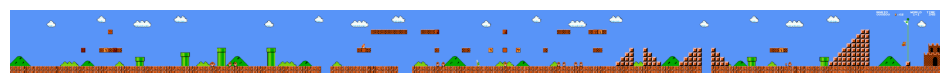

Creating background for level w1l2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l2_rep-001.bk2
Saved mosaic as 'background.png'.


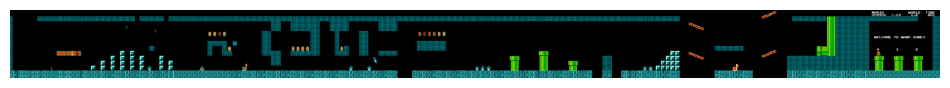

Creating background for level w1l3
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l3_rep-002.bk2
Saved mosaic as 'background.png'.


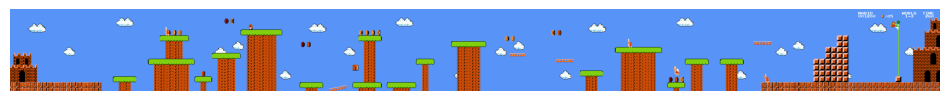

Creating background for level w2l1
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w2l1_rep-001.bk2
Saved mosaic as 'background.png'.


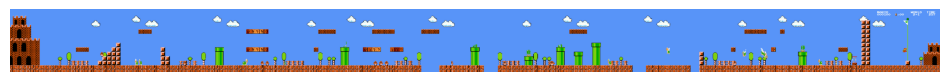

Creating background for level w2l3
Processing sub-01/ses-002/gamelogs/sub-01_ses-002_task-mario_level-w2l3_rep-000.bk2
Saved mosaic as 'background.png'.


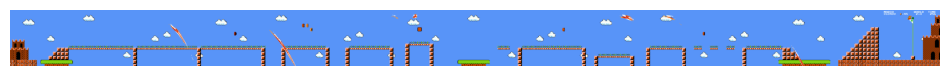

Creating background for level w3l1
Processing sub-01/ses-002/gamelogs/sub-01_ses-002_task-mario_level-w3l1_rep-001.bk2
Saved mosaic as 'background.png'.


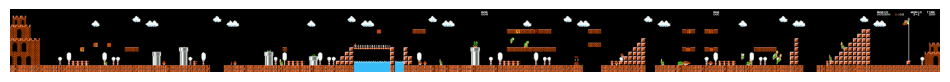

Creating background for level w3l2
Processing sub-01/ses-002/gamelogs/sub-01_ses-002_task-mario_level-w3l2_rep-000.bk2
Saved mosaic as 'background.png'.


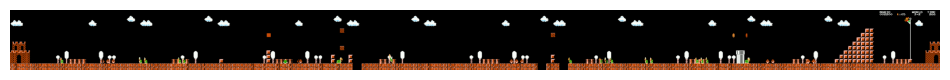

Creating background for level w3l3
Processing sub-01/ses-003/gamelogs/sub-01_ses-003_task-mario_level-w3l3_rep-000.bk2
Saved mosaic as 'background.png'.


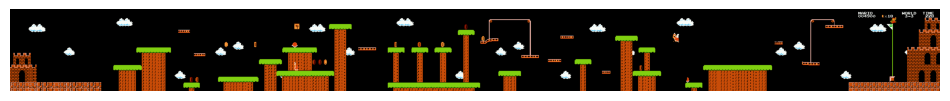

Creating background for level w4l1
Processing sub-01/ses-003/gamelogs/sub-01_ses-003_task-mario_level-w4l1_rep-000.bk2
Saved mosaic as 'background.png'.


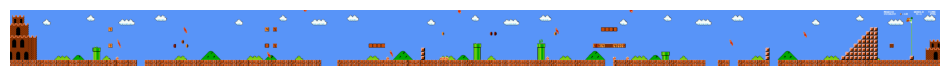

Creating background for level w4l2
Processing sub-01/ses-003/gamelogs/sub-01_ses-003_task-mario_level-w4l2_rep-000.bk2
Saved mosaic as 'background.png'.


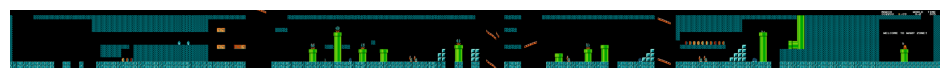

Creating background for level w4l3
Processing sub-01/ses-003/gamelogs/sub-01_ses-003_task-mario_level-w4l3_rep-000.bk2
Saved mosaic as 'background.png'.


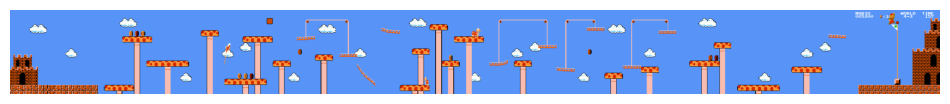

Creating background for level w5l1
Processing sub-01/ses-003/gamelogs/sub-01_ses-003_task-mario_level-w5l1_rep-000.bk2
Saved mosaic as 'background.png'.


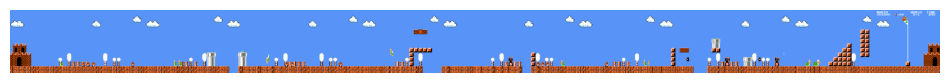

Creating background for level w5l2
Processing sub-01/ses-004/gamelogs/sub-01_ses-004_task-mario_level-w5l2_rep-003.bk2
Saved mosaic as 'background.png'.


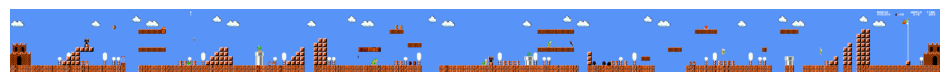

Creating background for level w5l3
Processing sub-01/ses-004/gamelogs/sub-01_ses-004_task-mario_level-w5l3_rep-001.bk2
Saved mosaic as 'background.png'.


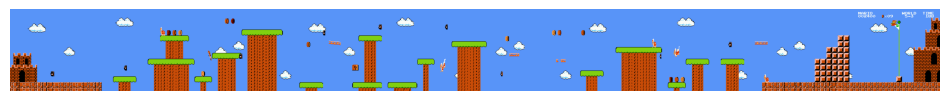

Creating background for level w6l1
Processing sub-01/ses-004/gamelogs/sub-01_ses-004_task-mario_level-w6l1_rep-002.bk2
Saved mosaic as 'background.png'.


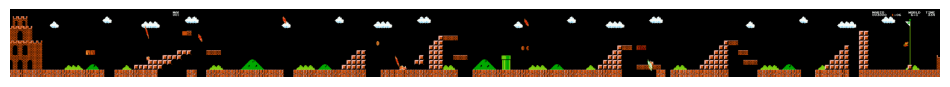

Creating background for level w6l2
Processing sub-01/ses-004/gamelogs/sub-01_ses-004_task-mario_level-w6l2_rep-000.bk2
Saved mosaic as 'background.png'.


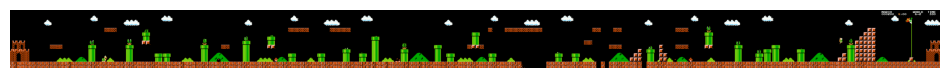

Creating background for level w6l3
Processing sub-01/ses-005/gamelogs/sub-01_ses-005_task-mario_level-w6l3_rep-002.bk2
Saved mosaic as 'background.png'.


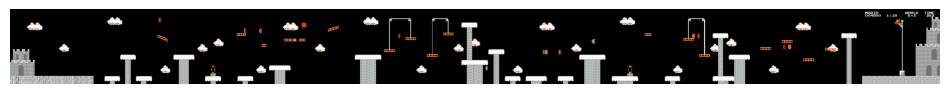

Creating background for level w7l1
Processing sub-01/ses-005/gamelogs/sub-01_ses-005_task-mario_level-w7l1_rep-002.bk2
Saved mosaic as 'background.png'.


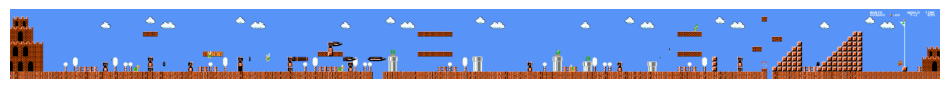

Creating background for level w7l3
Processing sub-01/ses-005/gamelogs/sub-01_ses-005_task-mario_level-w7l3_rep-001.bk2
Saved mosaic as 'background.png'.


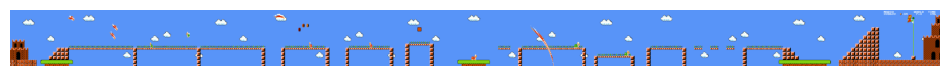

Creating background for level w8l1
Processing sub-01/ses-005/gamelogs/sub-01_ses-005_task-mario_level-w8l1_rep-001.bk2
Saved mosaic as 'background.png'.


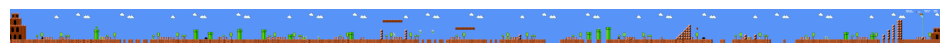

Creating background for level w8l2
Processing sub-01/ses-006/gamelogs/sub-01_ses-006_task-mario_level-w8l2_rep-005.bk2
Saved mosaic as 'background.png'.


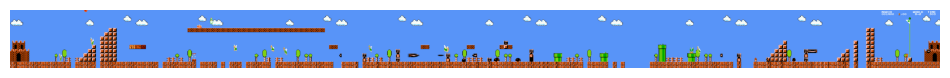

Creating background for level w8l3
Processing sub-01/ses-006/gamelogs/sub-01_ses-006_task-mario_level-w8l3_rep-010.bk2
Saved mosaic as 'background.png'.


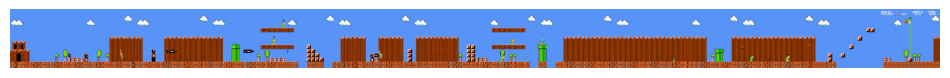

In [81]:
### Other alternative : use the full frame each time
import json

level_list = np.unique([x[:4] for x in scenes_info_dict.keys()])
for level_todo in level_list:
    print(f'Creating background for level {level_todo}')
    # First, accumulate columns across all the replays for this level
    level_collected = False
    background_frame = None
    
    scenes_in_level = [x for x in scenes_info_dict.keys() if x[:4] == level_todo]
    layouts = [scenes_info_dict[x]['level_layout'] for x in scenes_in_level]
    values, counts = np.unique(layouts, return_counts=True)
    most_common_layout = values[np.argsort(counts)[-1]]
    
    max_level_position = get_max_position(replays_dir, level_fullname=level_todo)
    
    columns_to_fill = np.ones(max_level_position)

    for bk2_info in bk2_list:
        if not level_collected:
            sidecar_name = op.join(replays_dir, bk2_info['bk2_file']).replace('.bk2','.json')
            with open(sidecar_name, 'r') as f:
                sidecar_info = json.load(f)

            bk2_file = bk2_info['bk2_file']
            skip_first_step = bk2_info['bk2_idx'] == 0
            bk2_level_fullname = bk2_info['bk2_file'].split('_')[-2].split('-')[1]
            if bk2_level_fullname == level_todo:
                if sidecar_info['Cleared'] == True:

                    print(f'Processing {bk2_file}')
                    # Replace with the actual path to your replay file.
                    bk2_file = op.join(DATA_PATH, bk2_file)

                    # Create the mosaic:
                    # Here, skip_first_step=True, level_layout is set to 144,
                    # and we accumulate the rightmost 3 columns from subsequent valid frames.
                    # First, load the replay data outside of the function.
                    bk2_file = op.join(DATA_PATH, bk2_file)
                    repetition_variables, replay_info, replay_frames, replay_states = get_variables_from_replay(
                        bk2_file, skip_first_step=skip_first_step
                    )

                    # Create the mosaic using the desired parameters.
                    # Here, we use level_layout 144 and accumulate the rightmost 3 columns for frames after the first valid frame.
                    mosaic_img = create_mosaic_from_replay(repetition_variables, replay_frames, level_layout=most_common_layout, columns_per_frame=240)

                    level_collected = True
                    # Save the mosaic image as "background.png" (convert from RGB to BGR for OpenCV).
                    cv2.imwrite(f"{level_todo}.png", cv2.cvtColor(mosaic_img, cv2.COLOR_RGB2BGR))
                    print("Saved mosaic as 'background.png'.")

                    # Display the mosaic in the notebook.
                    plt.figure(figsize=(12, 6))
                    plt.imshow(mosaic_img)
                    plt.axis("off")
                    plt.show()


np.int64(3148)

In [131]:
batch_columns_size = 10
    
for scene_fullname in scenes_info_dict.keys():
    print(f'Creating background for scene {scene_fullname}')
    scene_collected = False
    scene_layout = None
    start = scenes_info_dict[scene_fullname]['start']
    end = scenes_info_dict[scene_fullname]['end']

    global_columns_dict = {}
    for i in range(end-start+1):
        global_columns_dict[i] = []

    level_layout = scenes_info_dict[scene_fullname]['level_layout']
    level_fullname = scene_fullname[:4]
    max_level_position = get_max_position(replays_dir, level_fullname=level_fullname)

    for bk2_info in bk2_list:
        if not scene_collected:
            bk2_file = bk2_info['bk2_file']
            skip_first_step = bk2_info['bk2_idx'] == 0
            bk2_level_fullname = bk2_info['bk2_file'].split('_')[-2].split('-')[1]
            if bk2_level_fullname == level_fullname:
                print(f'Processing {bk2_file}')
                repetition_variables, replay_info, replay_frames, replay_states = get_variables_from_replay(
                    op.join(DATA_PATH, bk2_file),
                    skip_first_step=skip_first_step
                )
                # compute long version of x variables
                repetition_variables['player_x_pos'] = [
                    hi * 256 + lo for hi, lo in zip(repetition_variables['player_x_posHi'], repetition_variables['player_x_posLo'])
                ]
                repetition_variables['scroll_x_pos'] = [
                    hi * 256 + lo for hi, lo in zip(repetition_variables['xscrollHi'], repetition_variables['xscrollLo'])
                ]


                #if needed, init scene_layout
                if scene_layout is None:
                    scene_layout = np.zeros((replay_frames[0].shape[0], end-start+1, replay_frames[0].shape[2]))


                #all_columns_filled_for_this_rep = False
                #columns_to_fill = np.ones(end-start+1, dtype=bool)

                for i, frame in enumerate(replay_frames):
                    #print(f'current x scroll : {repetition_variables["scroll_x_pos"][i]}')
                    if repetition_variables['scroll_x_pos'][i] >= start and repetition_variables['scroll_x_pos'][i] <= end:
                        if repetition_variables['level_layout'][i] == level_layout:
                            current_column = repetition_variables['scroll_x_pos'][i]-start
                            #print(current_column)
                            for ii in range(0, batch_columns_size):
                                try:
                                    #if columns_to_fill[current_column+ii]:
                                    global_columns_dict[current_column+ii].append(frame[:,ii,:])
                                        #columns_to_fill[current_column+ii] = False
                                except:
                                    continue
                            
                            #if not columns_to_fill.any():
                                #scene_collected = True
                                #all_columns_filled_for_this_rep = True
                                #break
                
    
    for i in range(0, end-start+1):
        column = mode_array(global_columns_dict[i])
        scene_layout[:,i,:] = column
        print(f'Column {i} done')
    
    img = Image.fromarray(np.uint8(scene_layout))
    os.makedirs(op.join('..', 'resources', 'scene_backgrounds'), exist_ok=True)
    img.save(op.join('..', 'resources', 'scene_backgrounds', f'{scene_fullname}.png'))






Creating background for scene w1l1s0
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-001.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-002.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-003.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-004.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-005.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-006.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-007.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-008.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-009.bk2
Processing sub-01/ses-001/gamelogs/sub-01_ses-001_task-mario_level-w1l1_rep-010.bk2
Processing sub-01/ses-007/gamelogs/sub-

IndexError: list index out of range

In [116]:
    
    for i in range(0, end-start+1):
        column = mode_array(global_columns_dict[i])
        scene_layout[:,i,:] = column
        print(f'Column {i} done')
    
    img = Image.fromarray(np.uint8(scene_layout))
    os.makedirs(op.join('..', 'resources', 'scene_backgrounds'), exist_ok=True)
    img.save(op.join('..', 'resources', 'scene_backgrounds', f'{scene_fullname}.png'))



Column 0 done
Column 1 done
Column 2 done
Column 3 done
Column 4 done
Column 5 done
Column 6 done
Column 7 done
Column 8 done
Column 9 done
Column 10 done
Column 11 done
Column 12 done
Column 13 done
Column 14 done
Column 15 done
Column 16 done
Column 17 done
Column 18 done
Column 19 done
Column 20 done
Column 21 done
Column 22 done
Column 23 done
Column 24 done
Column 25 done
Column 26 done
Column 27 done
Column 28 done
Column 29 done
Column 30 done
Column 31 done
Column 32 done
Column 33 done
Column 34 done
Column 35 done
Column 36 done
Column 37 done
Column 38 done
Column 39 done
Column 40 done
Column 41 done
Column 42 done
Column 43 done
Column 44 done
Column 45 done
Column 46 done
Column 47 done
Column 48 done
Column 49 done
Column 50 done
Column 51 done
Column 52 done
Column 53 done
Column 54 done
Column 55 done
Column 56 done
Column 57 done
Column 58 done
Column 59 done
Column 60 done
Column 61 done
Column 62 done
Column 63 done
Column 64 done
Column 65 done
Column 66 done
Colum

KeyboardInterrupt: 

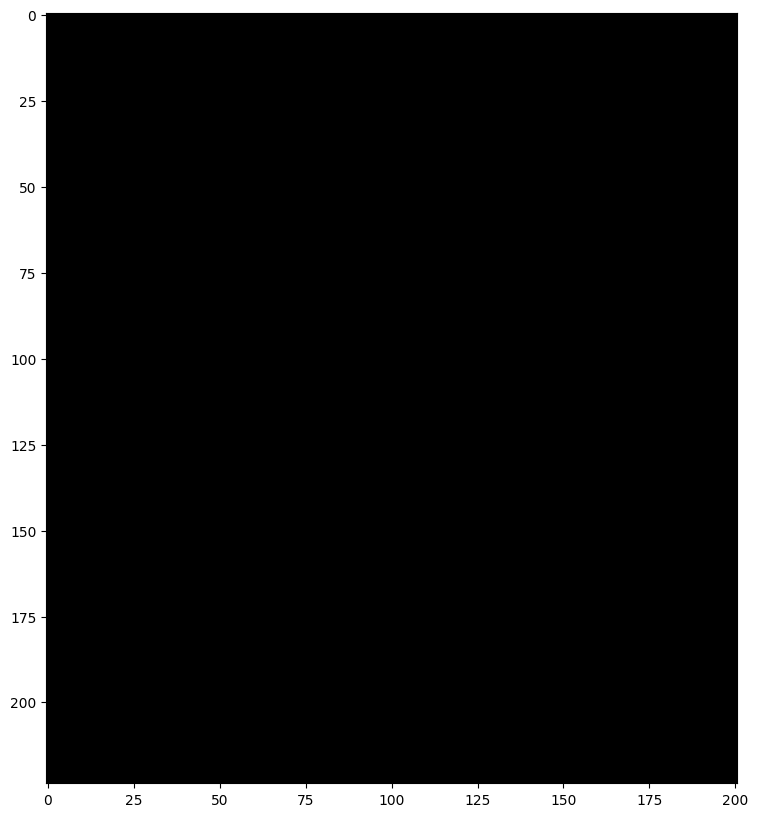

In [12]:
MAX_LEVEL_SIZE=10000
def generate_map(bk2_path, skip_first_step=False):
    max_scroll_r = 0
    design = None
    for frame, keys, annotations, truncate, sound in replay_bk2(bk2_path, skip_first_step=skip_first_step):
        if design is None:
            design = np.zeros((frame.shape[0], MAX_LEVEL_SIZE, frame.shape[2]))
            cols = np.ones(MAX_LEVEL_SIZE, dtype=bool)
        scroll_x_pos = annotations["info"]["xscrollHi"] * 256 + annotations["info"]["xscrollLo"]
        scroll_x_pos_r = scroll_x_pos+frame.shape[1]
    
        if scroll_x_pos == 0:
            if cols[0] and annotations["info"]["player_x_posLo"] > 0:
                design[:,:frame.shape[1]] = frame
                cols[:frame.shape[1]] = False
        else:
            design[:,:scroll_x_pos_r][:,cols[:scroll_x_pos_r]] = frame[:,cols[scroll_x_pos:scroll_x_pos_r]]
            cols[scroll_x_pos:scroll_x_pos_r] = False
        max_scroll_r = max(max_scroll_r, scroll_x_pos_r)
    design = design[:,:max_scroll_r]
    return design

In [4]:
events_paths = sorted(glob.glob("/media/hyruuk/Commons/GitHub/neuromod/mario_projects/mario.scenes/data/mario/sub-03/ses-*/func/*_events.tsv"))
events = [pd.read_csv(ep,delimiter="\t") for ep in events_paths]

In [5]:
reps = sorted(glob.glob("/media/hyruuk/Commons/GitHub/neuromod/mario_projects/mario.scenes/data/mario/sub-03/ses-*/gamelogs/*_task-mario_level-w8l2_rep-*.bk2"))
len(reps)

40

In [6]:
first_rep = [ any([evts.stim_file[0] in rep for evts in events]) for rep in reps]
np.where(first_rep)

(array([ 0,  8, 14, 32, 34]),)

In [14]:
reps_data = []
for rep,skip_first_step in zip(reps, first_rep):
    reps_data.append((rep, [annotations["info"] for frame, keys, annotations, sound in replay_bk2(rep, skip_first_step=skip_first_step)]))

    

RuntimeError: Cannot create multiple emulator instances per process, make sure to call env.close() on each environment before creating a new one

In [9]:
reps_x_pos = [np.asarray([d["player_x_posLo"] + d["player_x_posHi"]*256 for d in rep_data[1]]) for rep_data in reps_data]
rep_xmax = np.argmax([max(x_pos) for x_pos in reps_x_pos])

ValueError: attempt to get argmax of an empty sequence

In [11]:
from matplotlib.pyplot import subplots

design = generate_map(reps[rep_xmax], skip_first_step=first_rep[rep_xmax])
f,ax = subplots(1,1,figsize=(64,2))
ax.imshow(design/255.)

NameError: name 'generate_map' is not defined

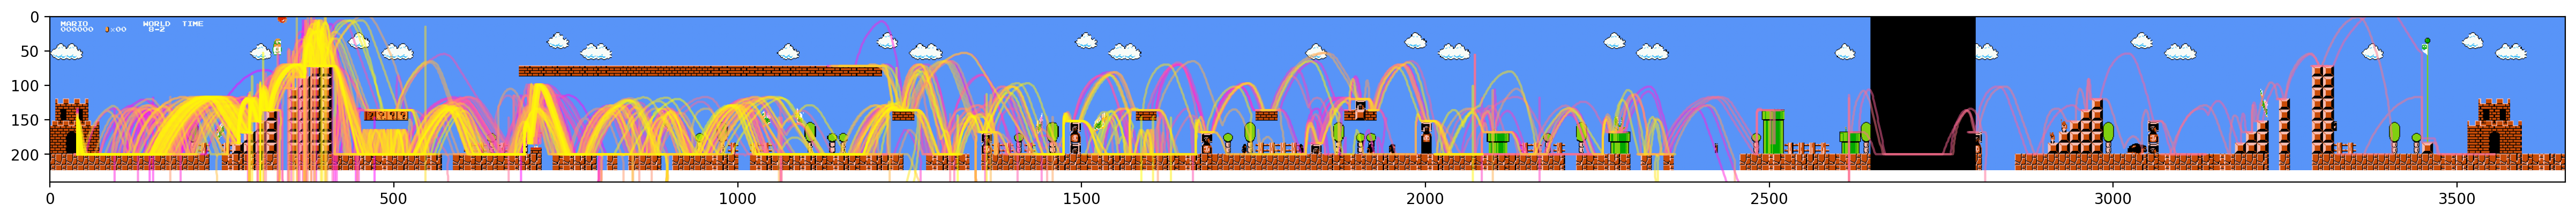

In [475]:
f,ax = subplots(1,1,figsize=(64,2))
ax.imshow(design/255.)

for rep_data, rep_x_pos in zip(reps_data, reps_x_pos):
    pstate = np.asarray([d["player_state"] for d in rep_data[1]])
    y_pos = np.asarray([float(d["player_y_pos"])+24-(1-d["player_y_screen_pos"])*256 for d in rep_data[1]])
    y_pos = np.ma.masked_where(pstate==0, y_pos)
    ax.plot(rep_x_pos, y_pos)
ax.set_ylim(240,0)

colormap = plt.cm.spring
colors = np.asarray([colormap(i) for i in np.linspace(0, 1,len(ax.lines))])
colors[:,-1]=.5
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

24

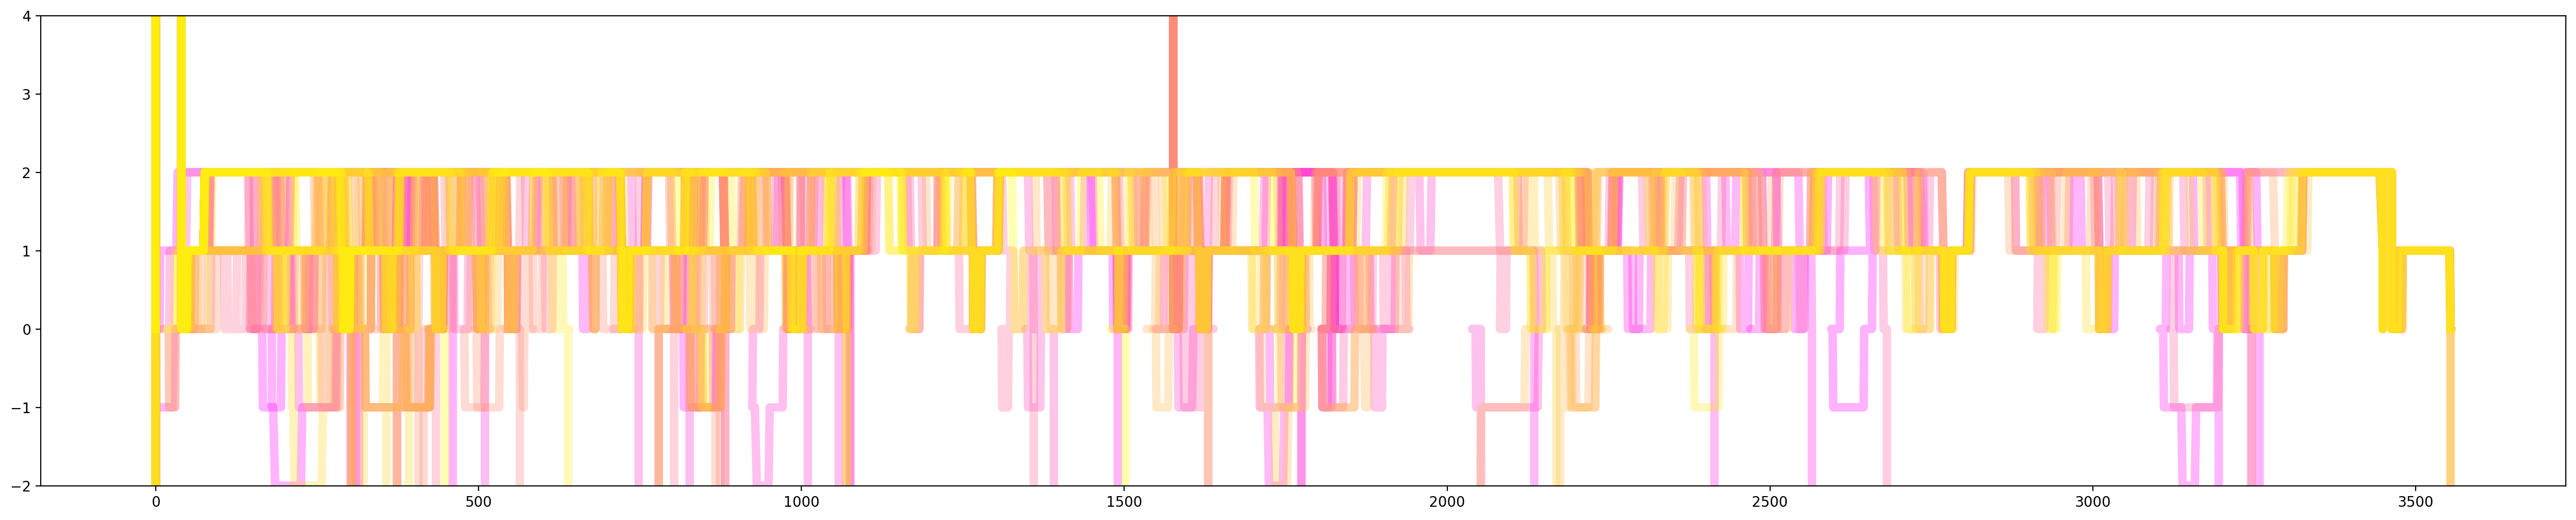

In [383]:
f,ax = subplots(1,1,figsize=(32,6))
for rep_data in reps_data:
    x_pos = np.asarray([d["player_x_posLo"] + d["player_x_posHi"]*256. for d in rep_data[1]],dtype=np.int32)
    #x_pos_mf = x_pos,4, mode='constant')
    ax.plot(x_pos, scipy.ndimage.gaussian_filter(np.ediff1d(x_pos, to_begin=[0]),2), linewidth=6)
ax.set_ylim([-2,4])
colors = np.asarray([colormap(i) for i in np.linspace(0, 1,len(ax.lines))])
colors[:,-1]=.3
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

In [478]:
max_x = (np.max([np.max(rep_x_pos) for rep_x_pos in reps_x_pos ]))//6+1
MAX_NUM_LIVES=3 + 5 # 3 lives + 5 bonus
survival_indexed = np.empty((len(reps_data)*MAX_NUM_LIVES, max_x), dtype=np.float16)
survival_indexed.fill(np.nan)
index = np.zeros(max_x, dtype=np.int32)
for rep_idx, x_pos in enumerate(reps_x_pos):
    uniq_x_pos = np.unique(x_pos//6) #only counts position once per rep
    np.put(survival_indexed, np.ravel_multi_index(np.asanyarray([index[uniq_x_pos],uniq_x_pos]), survival_indexed.shape), rep_idx)
    index[uniq_x_pos]+=1
survival_indexed=survival_indexed[:max(index)+1]

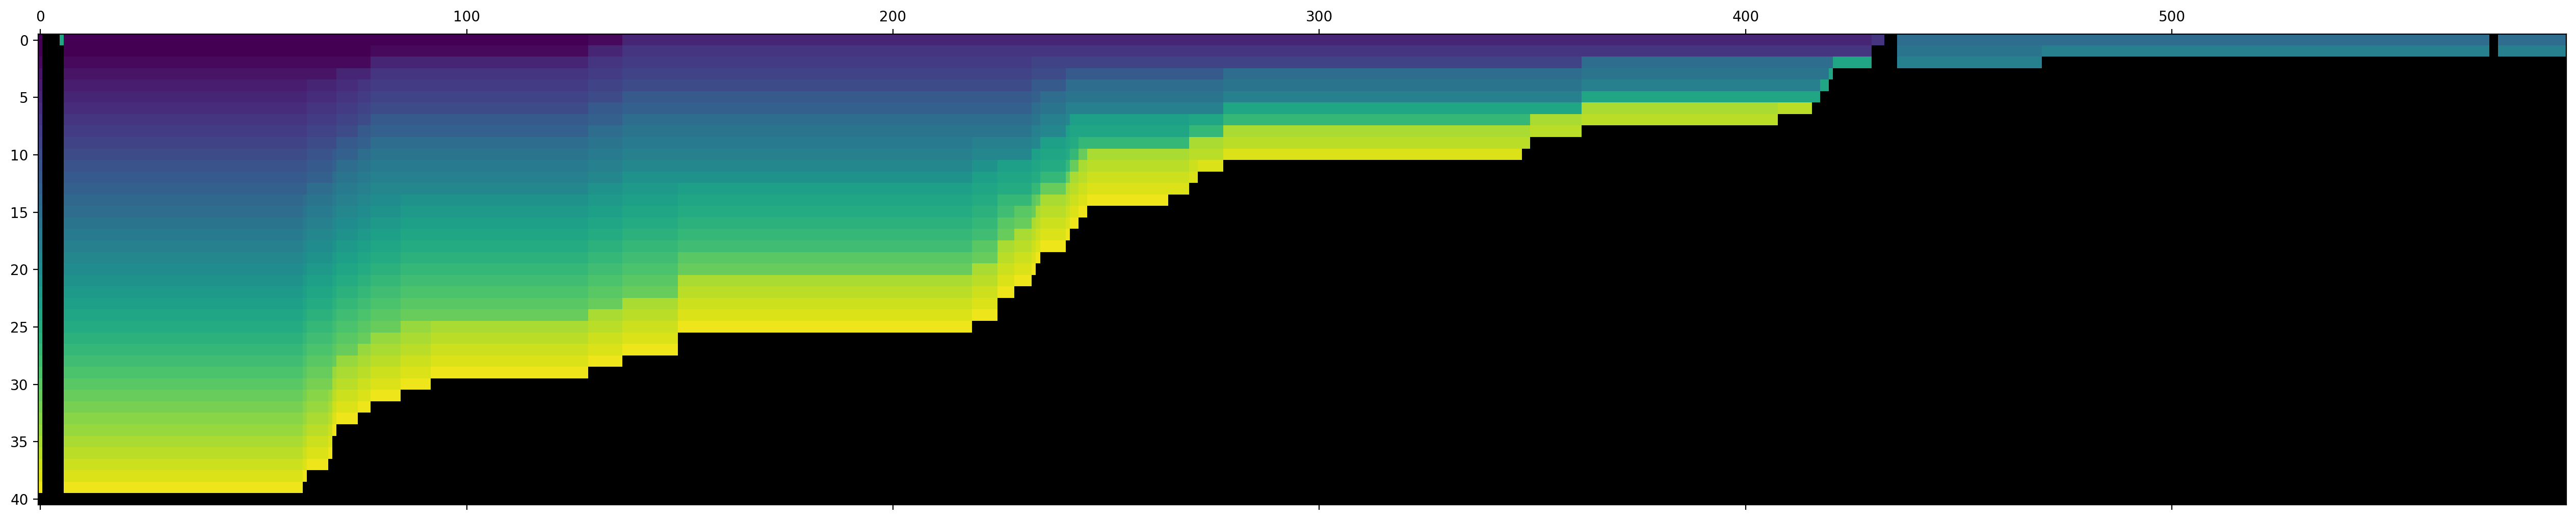

In [479]:
f,ax = subplots(1,1,figsize=(32,6))
cmap = matplotlib.cm.viridis
cmap.set_bad('black',1.)
survival_indexed_masked = np.ma.array (survival_indexed, mask=np.isnan(survival_indexed))
ax.matshow(survival_indexed_masked, aspect='auto', vmin=1, vmax=len(reps_data), cmap=cmap)

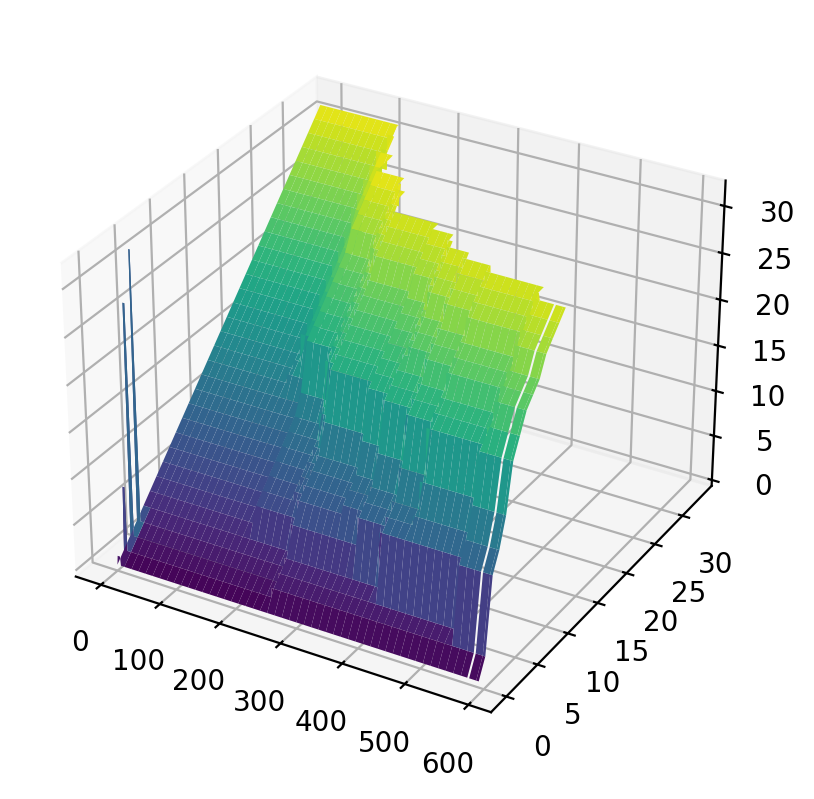

In [393]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xv, yv = np.meshgrid(np.arange(survival_indexed.shape[1]),np.arange(survival_indexed.shape[0]))
ax.plot_surface(xv,yv,survival_indexed_masked, cmap='viridis',vmin=0,vmax=len(reps_data))

In [427]:
np.unique([d["player_y_screen_pos"]+24 for d in rep_data[1]])

array([24, 25, 26, 27, 28])

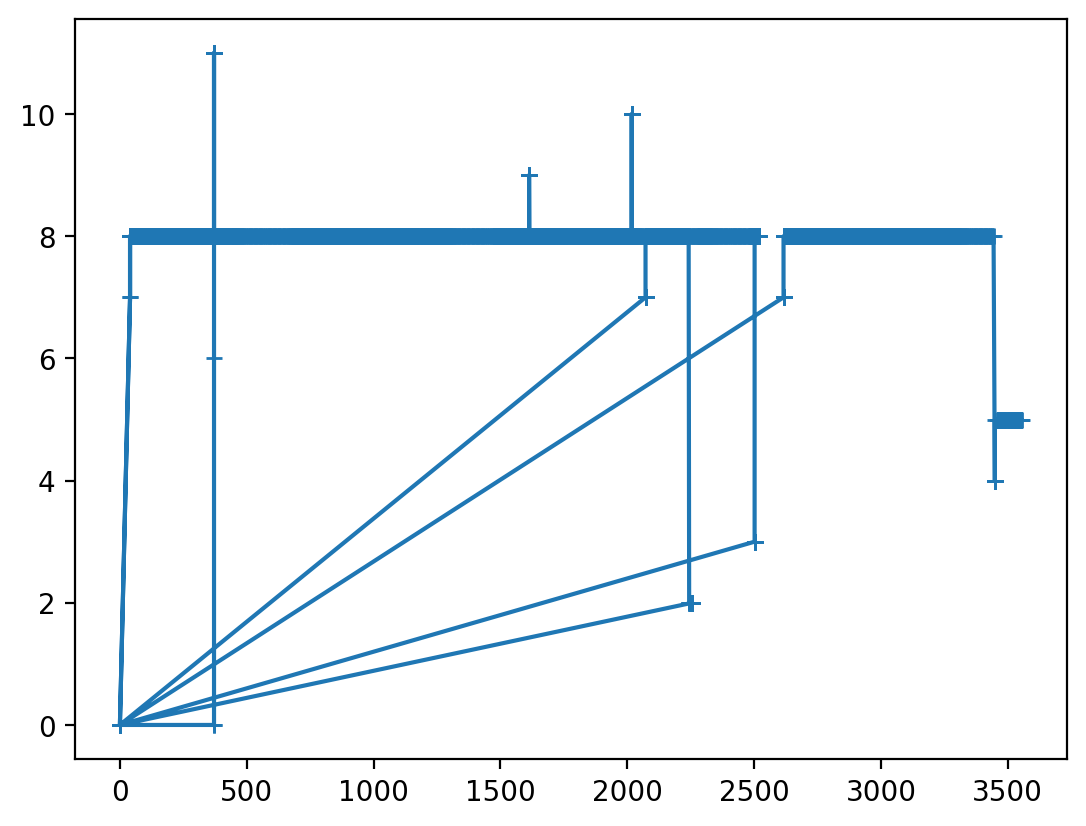

In [483]:
plot(reps_x_pos[rep_xmax],[d["player_state"] for d in reps_data[rep_xmax][1]],'+-')

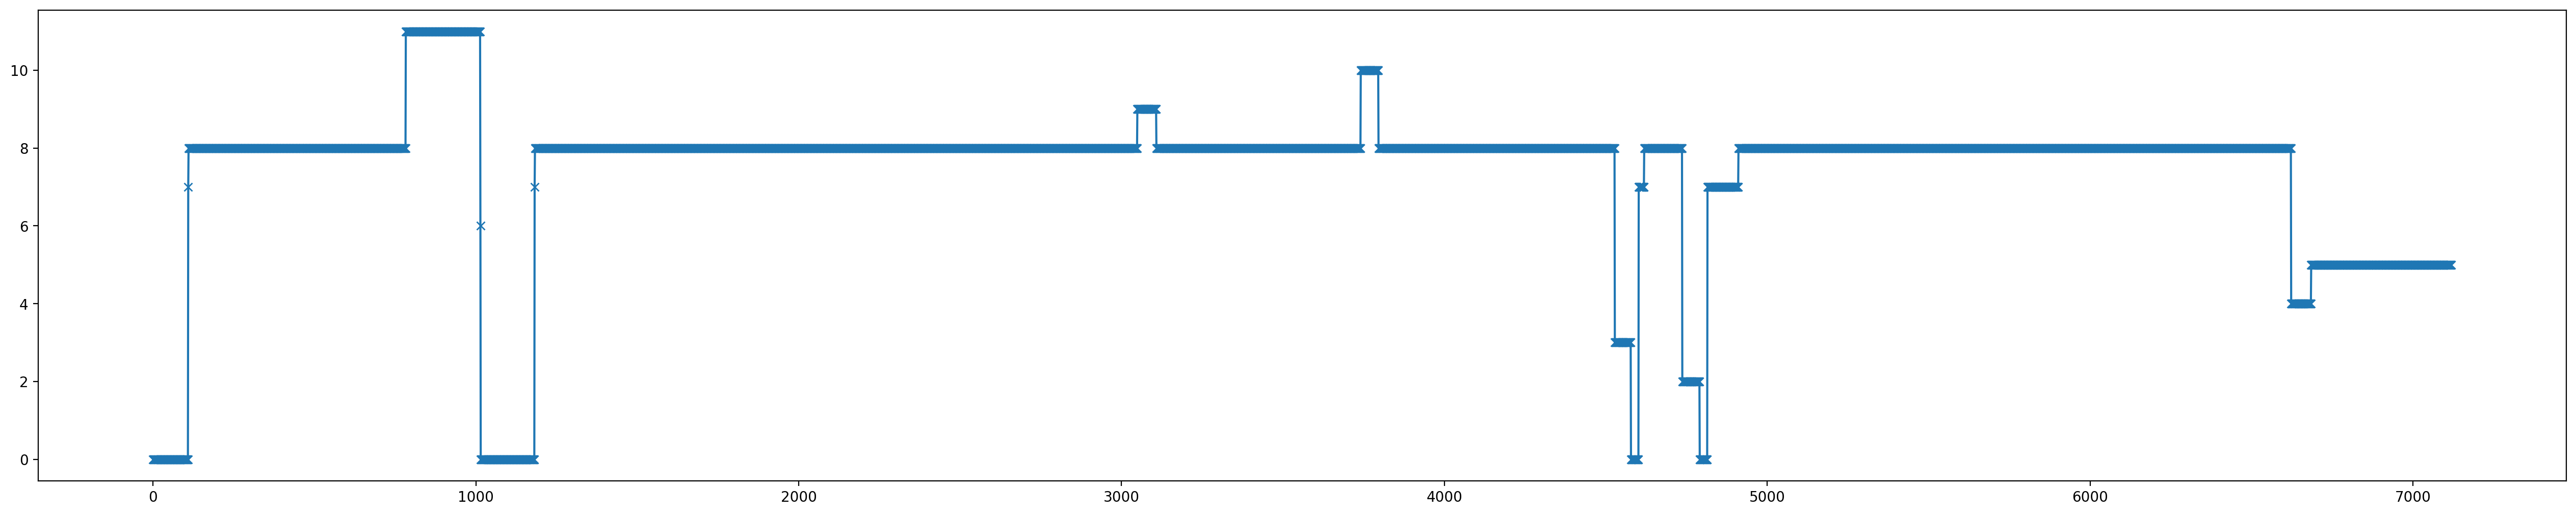

In [485]:
f,ax = subplots(1,1,figsize=(32,6))
ax.plot([d["player_state"] for d in reps_data[rep_xmax][1]],'-x')

In [428]:
rep_data = [annotations["info"] for frame, keys, annotations, sound in replay_bk2(rep)]

In [440]:
np.bincount([d['player_y_screen_pos'] for d in rep_data[1] ] )

array([ 462, 3121,  180,  183,  409])